In [1]:
# Import the required packages #################################################

from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from prefig import Prefig
from calc_kcor import calc_kcor

Prefig()

% matplotlib inline

cosmo=FlatLambdaCDM(H0=70,Om0=0.3) # Use standard cosmology model from astropy.

data_file = 'full_sample_w_urls_and_sfrs.fits'
data_dir = '../../fits/'
save_dir = '../../fits/'
fig_dir = '../../figures/samples/'

In [2]:
data = fits.getdata(data_dir+data_file,1)
cols=["PETROMAG_MR","REDSHIFT_1","PETROMAG_R"]
data_table=np.array([data.field(c) for c in cols]).T

data_table = Table(data_table,names=('Mag','redshift','mag'))

# Set the minimum redshift limit:
z_min = 0.03
data_table = data_table[data_table['redshift'] > z_min]

In [3]:
def get_sample_limits(z,table):

    z_max=[z] # Define the maximum redshift.
    D_max=(10**6)*(np.array(cosmo.luminosity_distance(z_max))[0]) # Define the
    # maximum distance from the max redshift.

    m_limit=17 # Maximum apparent magnitude to be used to cut the sample.
    
    k_val = calc_kcor('r',z,'g - r',0.8)
    
    M_limit=m_limit - 5*(math.log10(D_max) - 1) - k_val # Calculates abs. mag from apparent 
    # mag. Kcorr ~0.1 assuming U-R is ~3.
    
    #select = ((table['Mag'] < M_r_max) 
              #& (table['redshift'] < z) 
              #& (table['mag'] < m_r_max))

    return z_max,M_limit

In [4]:
def output_vls_sizes(table,N_steps=1000):
    
    z_vals = np.linspace(np.min(table['redshift']),np.max(table['redshift']),N_steps)
    # Replace the value closest to 0.085 with the exact value 
    # (as it is a 'special' value where we have environment data)
    z_vals[find_nearest(z_vals,0.085)] = 0.085
    
    sizes=np.zeros((N_steps,2))

    for z in enumerate(z_vals):
        z_max,M_limit = get_sample_limits(z=z[1],table=table)
        select = ((table['Mag'] <= M_limit) & (table['redshift'] <= z_max) 
                  & (table['redshift'] >= z_min))# & (table['mag'] <= 17))
        sizes[z[0],:] = np.array([z[1],np.sum(select)])
  
    sizes = Table(sizes,names=('redshift','N_gal'))
        
    return sizes

In [5]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def plot_line(max_sample,style,label):
    
    lines=np.array([[0,max_sample[0],max_sample[0]],[max_sample[1],max_sample[1],0]])
    plt.plot(lines[0],lines[1],style,label=label,linewidth=2)

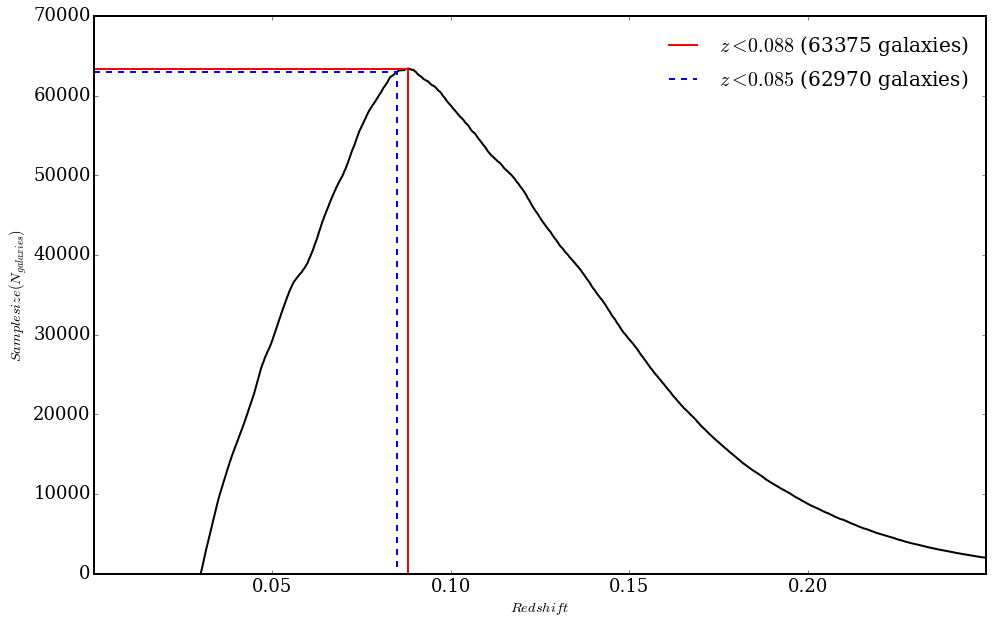

In [6]:
plt.figure(figsize=(16,10))

styles=["b--","g:"]

sizes=output_vls_sizes(table=data_table,N_steps=1000)

plt.plot(sizes['redshift'],sizes['N_gal'],"k-",linewidth=2)

max_sample=sizes[np.argmax(sizes['N_gal'])]
plot_line(max_sample,"r-",label="$z<{0:.3f}$".format(max_sample[0]) 
          + " ({0:.0f} galaxies)".format(max_sample[1]))

for z in enumerate([0.085]):
    
    max_sample=sizes[find_nearest(array=sizes['redshift'],value=z[1])]
    plot_line(max_sample,styles[z[0]],label="$z<{0:.3f}$".format(max_sample[0]) 
              + " ({0:.0f} galaxies)".format(max_sample[1]))

    
plt.xlabel("$Redshift$")
plt.ylabel("$Sample size (N_{galaxies})$")
plt.xticks(np.arange(0.05,0.25,0.05))
plt.legend(fontsize=20,frameon=False)
        
plt.savefig(fig_dir + 'sample_sizes.pdf')

In [7]:
def get_volume_limited_sample(z,table,maximise=False,z_min=0.03,plot=False):
    
    full_data = fits.getdata(data_dir + data_file,1)
    
    if maximise == True:
        sizes = output_vls_sizes(table=data_table)
        z = sizes[np.argmax(sizes['N_gal'])]['redshift']
    
    z_max,M_limit = get_sample_limits(z,table)
    
    select = ((full_data.field('REDSHIFT_1') >= z_min) 
              & (full_data.field('REDSHIFT_1') <= z_max) 
              & (full_data.field('PETROMAG_MR') <= M_limit))
              #& (full_data.field('PETROMAG_R') <= 17))
    
    
    if plot == True:
        
        plt.figure(figsize=(16,10))
        ax = plt.subplot(1,1,1)
        
        plt.scatter(full_data.field('REDSHIFT_1'),full_data.field('PETROMAG_MR'),
                 facecolor='red',alpha=0.5,s=3,edgecolor='none')
        
        plt.hlines(M_limit,z_min,z_max,'k')
        plt.vlines(z_min,M_limit,-25,'k')
        plt.vlines(z_max,M_limit,-25,'k')
        plt.text(0.9,0.9,'{} galaxies'.format(np.sum(select))
                ,ha='right',va='top',transform=ax.transAxes)
        
        plt.xlabel('$Redshift$')
        plt.ylabel('$M_r$')
        
        plt.xlim([0,0.26])
        plt.ylim([-16,-25])
        plt.savefig(fig_dir + 'volume_limited_sample.pdf',dpi=100)
        
    print('M_r limit = {}, {} galaxies in sample'.format(M_limit,np.sum(select)))
    
    return select

M_r limit = -21.006979342196836, 62970 galaxies in sample


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/backends/backend_pdf.py:2264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


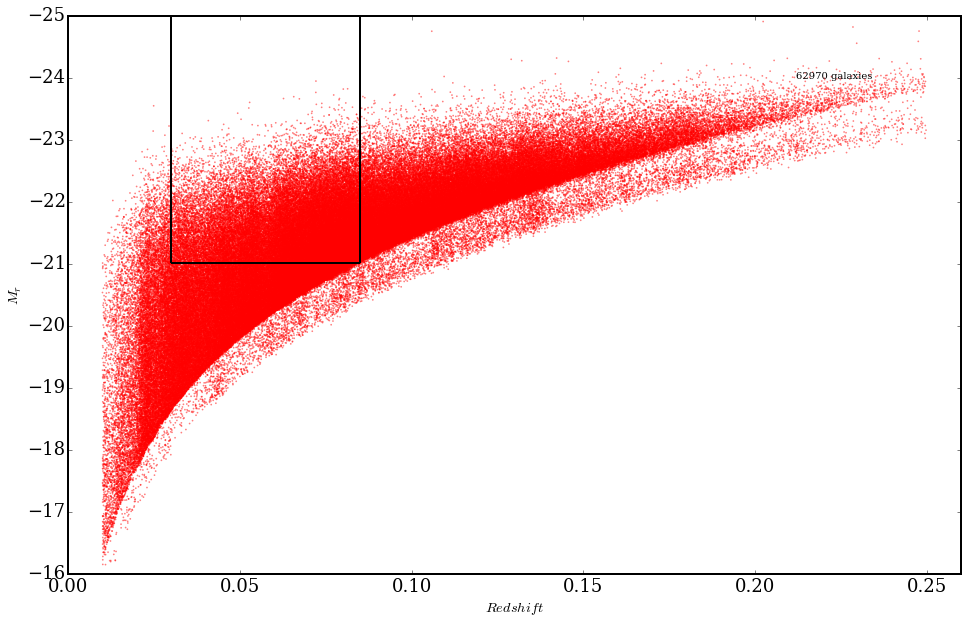

In [8]:
select = get_volume_limited_sample(z=0.085,table=data_table,maximise=False,z_min=0.03,plot=True)

#vl.write(save_dir + 'volume_limited_sample.fits',overwrite=True)
#full.write(save_dir + 'full_sample.fits',overwrite=True)

In [9]:
full = fits.getdata(data_dir + data_file,1)

full = Table(full)
vl = full[select]

vl.write(save_dir + 'volume_limited_sample.fits',overwrite=True)
full.write(save_dir + 'full_sample.fits',overwrite=True)

KeyboardInterrupt: 